In [35]:
import zipfile
zip_file = zipfile.ZipFile('word2vec-nlp-tutorial.zip', 'r')
zip_file.extractall()
zip_file.close()

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
import pandas as pd

train = pd.read_csv('labeledTrainData.tsv', header=0, delimiter="\t", quoting=3)
test = pd.read_csv('testData.tsv', header=0,  delimiter="\t", quoting=3)
unsup = pd.read_csv('unlabeledTrainData.tsv', header=0,  delimiter="\t", quoting=3)

In [38]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [39]:
from bs4 import BeautifulSoup
import re
#from nltk.corpus import stopwords

def text_to_wordlist(text):
    text = re.sub('n\'t', ' not', text)
    
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.lower().split()

    #stops = set(stopwords.words("english"))

    return words

In [40]:
import nltk.data

def text_to_sentences(text):
    text = BeautifulSoup(text).get_text()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(text.strip())
    
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            new_item = text_to_wordlist(raw_sentence)
            tokens_stem = [wordnet_lemmatizer.lemmatize(x, pos=wordnet.VERB) for x in new_item]
            sentences.append(tokens_stem)
    return sentences

In [41]:
%%time
sentences = []

for review in train["review"]:
    sentences += text_to_sentences(review)
    
for review in unsup["review"]:
    sentences += text_to_sentences(review)
    
for review in test["review"]:
    sentences += text_to_sentences(review)

CPU times: user 3min 45s, sys: 5.52 s, total: 3min 50s
Wall time: 3min 50s


In [8]:
print(len(sentences))

1059231


In [43]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

wordnet_lemmatizer = WordNetLemmatizer()

In [44]:
print ('\t Первый элемент массива')
print (sentences[0]) 
print ('\t Второй элемент массива')
print (sentences[1])

	 Первый элемент массива
['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'start', 'listen', 'to', 'his', 'music', 'watch', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watch', 'the', 'wiz', 'and', 'watch', 'moonwalker', 'again']
	 Второй элемент массива
['maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'think', 'be', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'be', 'guilty', 'or', 'innocent']


In [45]:
%%time
from gensim.models.word2vec import Word2Vec 

# список параметров, которые можно менять по вашему желанию
params = {}
params['size'] = 300  # итоговая размерность вектора каждого слова
params['min_count'] = 5  # минимальная частотность слова, чтобы оно попало в модель
params['workers'] = 8     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
params['window'] = 10        # размер окна 
params['sample'] = 1e-3 # внутренняя метрика модели

model = Word2Vec(sentences, **params)

CPU times: user 6min 2s, sys: 3.21 s, total: 6min 5s
Wall time: 1min 7s


In [46]:
model.init_sims(replace=True)

In [47]:
model.most_similar(positive=['queen', 'man'], negative=['king'])

[('woman', 0.6540571451187134),
 ('lady', 0.5571386218070984),
 ('housewife', 0.5190050601959229),
 ('girl', 0.5053339600563049),
 ('blonde', 0.49823594093322754),
 ('babe', 0.49788898229599),
 ('waif', 0.47060197591781616),
 ('brunette', 0.46918797492980957),
 ('widow', 0.46892082691192627),
 ('stripper', 0.4647114872932434)]

In [48]:
import numpy as np

def text_to_vec(words, model, size):
    text_vec = np.zeros((size,), dtype="float32")
    n_words = 0

    index2word_set = set(model.wv.vocab.keys())
    for word in words:
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model[word])
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

In [49]:
from tqdm import tqdm_notebook as tqdm
def texts_to_vecs(texts, model, size):
    texts_vecs = np.zeros((len(texts), size), dtype="float32")
    
    for i, text in tqdm(enumerate(texts),):
        texts_vecs[i] = text_to_vec(text, model, size)

    return texts_vecs

In [50]:
from tqdm import tqdm_notebook as tqdm
train_like_word_list = [sum(text_to_sentences(text), []) for text in tqdm(train['review'], total=len(train['review']))]

In [51]:
train_vecs = texts_to_vecs(train_like_word_list, model, params['size'])

In [52]:
test_like_word_list = [sum(text_to_sentences(text), []) for text in tqdm(test['review'])]

In [53]:
test_vecs = texts_to_vecs(test_like_word_list, model, params['size'])

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_vecs,  train["sentiment"])

In [153]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
parameters = {'n_estimators': [100, 200], 'max_features': [7,10,14,20,24], 'min_samples_leaf': [1,3,5], \
              'max_depth': [1,3,5,10,15]}
rfc = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=8, oob_score=True)
gcv = GridSearchCV(rfc, parameters, cv=skf, verbose=1)
gcv.fit(X_train, y_train)
predict_valid = forest.predict_proba(X_valid)
print(roc_auc_score(y_valid, predict_valid[:,1]))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=100, total=   0.6s
[CV] max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=100, total=   0.6s
[CV] max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=100, total=   0.6s
[CV] max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=100, total=   0.6s
[CV] max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=100, total=   0.6s
[CV] max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=200, total=   1.1s
[CV] max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=200, total=   1.1s
[CV] max_depth=1, max_features=7, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=1, max_features=7, min_samples

[CV]  max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=100, total=   0.7s
[CV] max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=100, total=   0.7s
[CV] max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=200, total=   1.0s
[CV] max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=200, total=   1.0s
[CV] max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=200, total=   1.0s
[CV] max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=200, total=   1.0s
[CV] max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=1, max_features=10

[CV]  max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=100, total=   0.8s
[CV] max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=200, total=   1.4s
[CV] max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=200, total=   1.4s
[CV] max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=200, total=   1.4s
[CV] max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=200, total=   1.5s
[CV] max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=200, total=   1.4s
[CV] max_depth=1, max_features=20, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=1, max_features=20

[CV]  max_depth=3, max_features=7, min_samples_leaf=1, n_estimators=200, total=   1.4s
[CV] max_depth=3, max_features=7, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=3, max_features=7, min_samples_leaf=1, n_estimators=200, total=   1.5s
[CV] max_depth=3, max_features=7, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=3, max_features=7, min_samples_leaf=1, n_estimators=200, total=   1.4s
[CV] max_depth=3, max_features=7, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=3, max_features=7, min_samples_leaf=1, n_estimators=200, total=   1.5s
[CV] max_depth=3, max_features=7, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=3, max_features=7, min_samples_leaf=1, n_estimators=200, total=   1.4s
[CV] max_depth=3, max_features=7, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=3, max_features=7, min_samples_leaf=3, n_estimators=100, total=   0.8s
[CV] max_depth=3, max_features=7, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=3, max_features=7, min_samples

[CV]  max_depth=3, max_features=10, min_samples_leaf=5, n_estimators=200, total=   1.6s
[CV] max_depth=3, max_features=10, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=3, max_features=10, min_samples_leaf=5, n_estimators=200, total=   1.7s
[CV] max_depth=3, max_features=10, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=3, max_features=10, min_samples_leaf=5, n_estimators=200, total=   1.6s
[CV] max_depth=3, max_features=14, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=3, max_features=14, min_samples_leaf=1, n_estimators=100, total=   1.2s
[CV] max_depth=3, max_features=14, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=3, max_features=14, min_samples_leaf=1, n_estimators=100, total=   1.2s
[CV] max_depth=3, max_features=14, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=3, max_features=14, min_samples_leaf=1, n_estimators=100, total=   1.2s
[CV] max_depth=3, max_features=14, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=3, max_features=14

[CV]  max_depth=3, max_features=20, min_samples_leaf=3, n_estimators=200, total=   2.5s
[CV] max_depth=3, max_features=20, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=3, max_features=20, min_samples_leaf=3, n_estimators=200, total=   2.5s
[CV] max_depth=3, max_features=20, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=3, max_features=20, min_samples_leaf=5, n_estimators=100, total=   1.4s
[CV] max_depth=3, max_features=20, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=3, max_features=20, min_samples_leaf=5, n_estimators=100, total=   1.4s
[CV] max_depth=3, max_features=20, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=3, max_features=20, min_samples_leaf=5, n_estimators=100, total=   1.4s
[CV] max_depth=3, max_features=20, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=3, max_features=20, min_samples_leaf=5, n_estimators=100, total=   1.4s
[CV] max_depth=3, max_features=20, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=3, max_features=20

[CV]  max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=100, total=   1.0s
[CV] max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=100, total=   1.0s
[CV] max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=100, total=   1.0s
[CV] max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=100, total=   1.0s
[CV] max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=100, total=   1.0s
[CV] max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=200, total=   1.8s
[CV] max_depth=5, max_features=7, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=5, max_features=7, min_samples

[CV]  max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=100, total=   1.5s
[CV] max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=100, total=   1.5s
[CV] max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=100, total=   1.5s
[CV] max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=200, total=   2.8s
[CV] max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=200, total=   2.8s
[CV] max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=200, total=   2.9s
[CV] max_depth=5, max_features=14, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=5, max_features=14

[CV]  max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=100, total=   2.0s
[CV] max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=100, total=   2.1s
[CV] max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=200, total=   3.7s
[CV] max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=200, total=   3.7s
[CV] max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=200, total=   3.7s
[CV] max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=200, total=   3.7s
[CV] max_depth=5, max_features=20, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=5, max_features=20

[CV]  max_depth=10, max_features=7, min_samples_leaf=3, n_estimators=100, total=   1.4s
[CV] max_depth=10, max_features=7, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=10, max_features=7, min_samples_leaf=3, n_estimators=200, total=   2.6s
[CV] max_depth=10, max_features=7, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=10, max_features=7, min_samples_leaf=3, n_estimators=200, total=   2.6s
[CV] max_depth=10, max_features=7, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=10, max_features=7, min_samples_leaf=3, n_estimators=200, total=   2.6s
[CV] max_depth=10, max_features=7, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=10, max_features=7, min_samples_leaf=3, n_estimators=200, total=   2.6s
[CV] max_depth=10, max_features=7, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=10, max_features=7, min_samples_leaf=3, n_estimators=200, total=   2.7s
[CV] max_depth=10, max_features=7, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=10, max_features=7

[CV]  max_depth=10, max_features=14, min_samples_leaf=1, n_estimators=200, total=   4.4s
[CV] max_depth=10, max_features=14, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, n_estimators=200, total=   4.3s
[CV] max_depth=10, max_features=14, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, n_estimators=200, total=   4.4s
[CV] max_depth=10, max_features=14, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, n_estimators=200, total=   4.4s
[CV] max_depth=10, max_features=14, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, n_estimators=200, total=   4.4s
[CV] max_depth=10, max_features=14, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, n_estimators=100, total=   2.3s
[CV] max_depth=10, max_features=14, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=10, ma

[CV]  max_depth=10, max_features=20, min_samples_leaf=5, n_estimators=200, total=  32.1s
[CV] max_depth=10, max_features=20, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=10, max_features=20, min_samples_leaf=5, n_estimators=200, total=  33.3s
[CV] max_depth=10, max_features=20, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=10, max_features=20, min_samples_leaf=5, n_estimators=200, total=  32.3s
[CV] max_depth=10, max_features=20, min_samples_leaf=5, n_estimators=200 
[CV]  max_depth=10, max_features=20, min_samples_leaf=5, n_estimators=200, total=  22.8s
[CV] max_depth=10, max_features=24, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=10, max_features=24, min_samples_leaf=1, n_estimators=100, total=  19.5s
[CV] max_depth=10, max_features=24, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=10, max_features=24, min_samples_leaf=1, n_estimators=100, total=  14.9s
[CV] max_depth=10, max_features=24, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=10, ma

[CV]  max_depth=15, max_features=7, min_samples_leaf=3, n_estimators=200, total=   3.0s
[CV] max_depth=15, max_features=7, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=15, max_features=7, min_samples_leaf=3, n_estimators=200, total=   3.0s
[CV] max_depth=15, max_features=7, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=15, max_features=7, min_samples_leaf=3, n_estimators=200, total=   3.1s
[CV] max_depth=15, max_features=7, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=15, max_features=7, min_samples_leaf=5, n_estimators=100, total=   1.6s
[CV] max_depth=15, max_features=7, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=15, max_features=7, min_samples_leaf=5, n_estimators=100, total=   1.5s
[CV] max_depth=15, max_features=7, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=15, max_features=7, min_samples_leaf=5, n_estimators=100, total=   1.6s
[CV] max_depth=15, max_features=7, min_samples_leaf=5, n_estimators=100 
[CV]  max_depth=15, max_features=7

[CV]  max_depth=15, max_features=14, min_samples_leaf=1, n_estimators=200, total=   5.2s
[CV] max_depth=15, max_features=14, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=15, max_features=14, min_samples_leaf=1, n_estimators=200, total=   5.2s
[CV] max_depth=15, max_features=14, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=15, max_features=14, min_samples_leaf=3, n_estimators=100, total=   2.6s
[CV] max_depth=15, max_features=14, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=15, max_features=14, min_samples_leaf=3, n_estimators=100, total=   2.7s
[CV] max_depth=15, max_features=14, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=15, max_features=14, min_samples_leaf=3, n_estimators=100, total=   2.6s
[CV] max_depth=15, max_features=14, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=15, max_features=14, min_samples_leaf=3, n_estimators=100, total=   2.7s
[CV] max_depth=15, max_features=14, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=15, ma

[CV]  max_depth=15, max_features=20, min_samples_leaf=5, n_estimators=200, total= 1.4min
[CV] max_depth=15, max_features=24, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=15, max_features=24, min_samples_leaf=1, n_estimators=100, total= 1.1min
[CV] max_depth=15, max_features=24, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=15, max_features=24, min_samples_leaf=1, n_estimators=100, total=  49.3s
[CV] max_depth=15, max_features=24, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=15, max_features=24, min_samples_leaf=1, n_estimators=100, total=  59.6s
[CV] max_depth=15, max_features=24, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=15, max_features=24, min_samples_leaf=1, n_estimators=100, total=  52.0s
[CV] max_depth=15, max_features=24, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=15, max_features=24, min_samples_leaf=1, n_estimators=100, total= 1.1min
[CV] max_depth=15, max_features=24, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=15, ma

[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed: 70.0min finished


ValueError: Number of features of the model must match the input. Model n_features is 1000 and input n_features is 300 

In [ ]:
gcv.best_estimator_, gcv.best_score_
predict = gcv.predict_proba(X_test)
labels = [0 if x > 0.5 else 1 for x in predict[:,1]]

fin = pd.DataFrame(columns=['id', 'sentiment'])

fin['id'] = test_ids.apply(lambda x: re.sub('"', '', x))
#fin['predict'] = predict
fin['sentiment'] = labels

fin.to_csv('~/lab05s.csv', header=True, index=False)

In [81]:
# Стандартный случайный лес в таком случае
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=8)
forest = forest.fit(X_train, y_train)
predict_valid = forest.predict_proba(X_valid)
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_valid, predict_valid[:,1]))

0.9138166912878649


0.9138166912878649


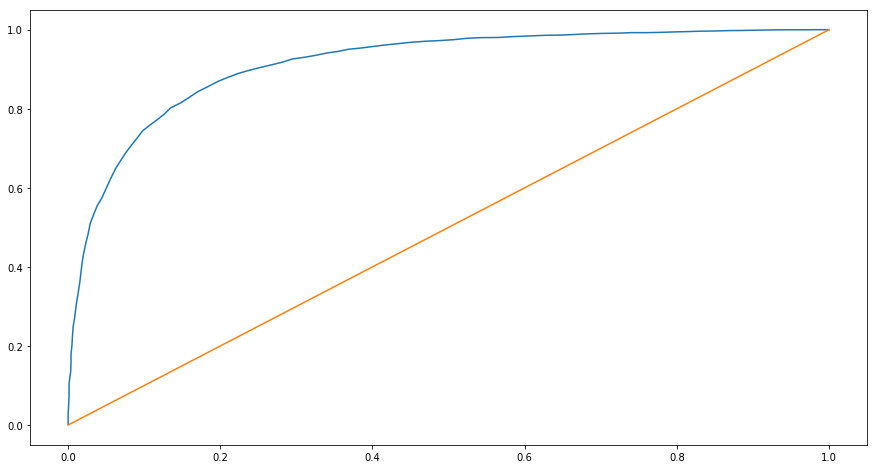

In [85]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
fpr, tpr, thresholds = roc_curve(y_valid, predict_valid[:,1])

plt.figure(figsize=(15,8))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
print(roc_auc_score(y_valid, predict_valid[:,1]))

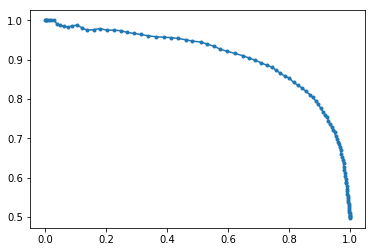

In [89]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_valid, predict_valid[:,1])
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

## Predict

In [55]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [56]:
X_test = test_vecs
test_ids = test["id"]

predict = forest.predict_proba(X_test)
labels = [1 if x > 0.5 else 0 for x in predict[:,1]]

fin = pd.DataFrame(columns=['id', 'sentiment'] )

fin['id'] = test_ids.apply(lambda x: re.sub('"', '', x))
fin['sentiment'] = labels

fin.to_csv('~/lab05s.csv', header=True, index=False)

In [90]:
predict = forest.predict_proba(X_test)

In [91]:
from matplotlib import pyplot as plt

In [95]:
labels = [1 if x > 0.5 else 0 for x in predict[:,1]]

In [96]:
fin = pd.DataFrame(columns=['id', 'sentiment'] )

fin['id'] = test_ids.apply(lambda x: re.sub('"', '', x))
fin['sentiment'] = labels

fin.to_csv('~/lab05s.csv', header=True, index=False)

## Кластеризация

In [98]:
%%time
# Кластеризируем все слова. 

from sklearn.cluster import KMeans

word_vectors = model.wv.syn0
# Число кластеров установим в 1000. Для этого числа нет "серебряной пули". Для каждого случая лучше подойдет разная
num_clusters = 1000

# Начнем кластеризацию, учитывая что классов много, количество векторов (по сути слов) много,
#   все это будет происходит продолжительное время. Можно сходить за чаем.
kmeans_clustering = KMeans(n_clusters=num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)

# в idx будут храниться номера классов для каждого слова

CPU times: user 1h 33min 31s, sys: 6min 45s, total: 1h 40min 16s
Wall time: 11min 9s


In [99]:
word_centroid_map = dict(zip(model.wv.index2word, idx))

In [ ]:
# import pickle
# pickle.dump(word_centroid_map,open('word_centroid_map.pkl','wb'))
# word_centroid_map = pickle.load(open('word_centroid_map.pkl','rb'))

In [102]:
clust = list(word_centroid_map.values())
wrds = list(word_centroid_map.keys())
for cluster in range(0,10):
    print (cluster)
    words = []

    for i in range(0, len(clust)):
        if clust[i] == cluster:
            words.append(wrds[i])
    print (words)

0
['firsthand', 'isla', 'belaney']
1
['forfeit', 'hibernation', 'smg', 'bf', 'linna', 'pleasuring', 'chink', 'westwood', 'mmmm', 'alfalfa', 'nos', 'hooters', 'screentime', 'cryin', 'jacuzzi', 'ruffians', 'sanitation', 'geddit', 'mommies', 'betts', 'nightgown', 'securities', 'isamar', 'gaol', 'toga', 'matarazzo', 'mast', 'confidentiality', 'arthritis', 'bloodstream', 'cornflakes', 'inconsolable', 'filet', 'volvo', 'airbrush', 'galley', 'hangups', 'defences', 'tylenol', 'hungrily', 'hags', 'girdle', 'pancreatic', 'westchester', 'turbans', 'daycare', 'detox', 'bazookas', 'kusanagi', 'nunally', 'labourer', 'hightail', 'gauzy', 'debrief', 'thorazine', 'calve', 'infections', 'caterers', 'downsize', 'mulch', 'thermometer', 'darla', 'tensely', 'electroshock', 'mignon', 'splurge', 'applicants', 'trouser', 'riffle', 'cessna', 'rive', 'thebes', 'bridesmaids', 'zosh', 'dinsmore', 'aroma', 'meir', 'onlooker', 'fenwick', 'southampton', 'flinstones', 'hammock', 'cinematograph', 'weired', 'coupons', '

In [103]:
def create_bag_of_centroids(wordlist, word_centroid_map, num_centroids):
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    set_word_centroid_map = set(word_centroid_map.keys())
    
    for word in wordlist:
        if word in set_word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    return bag_of_centroids

In [104]:
%%time
train_vecs_centroids = np.zeros((train["review"].size, num_clusters), dtype="float32")

for i, text in enumerate(train_like_word_list):
    train_vecs_centroids[i] = create_bag_of_centroids(text, word_centroid_map, num_clusters)

test_vecs_centroids = np.zeros((test["review"].size, num_clusters), dtype="float32")

for i, text in enumerate(test_like_word_list):
    test_vecs_centroids[i] = create_bag_of_centroids(text, word_centroid_map, num_clusters)

CPU times: user 4min 1s, sys: 536 ms, total: 4min 1s
Wall time: 4min 1s


In [105]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=8)
forest = forest.fit(train_vecs_centroids, train["sentiment"])
predict = forest.predict(test_vecs_centroids)

In [107]:
predict

array([1, 0, 1, ..., 0, 1, 1])

In [110]:
train_vecs_centroids_dist = np.zeros((train["review"].size, num_clusters), dtype="float32")

from scipy.spatial import distance

for i, vec in tqdm(enumerate(train_vecs), total=len(train_vecs)):
    for j, center in enumerate(kmeans_clustering.cluster_centers_):
        train_vecs_centroids_dist[i][j] = distance.euclidean(vec, center)

In [111]:
train_vecs_centroids_dist.shape

(25000, 1000)

In [112]:
test_vecs_centroids_dist = np.zeros((test["review"].size, num_clusters), dtype="float32")

for i, vec in tqdm(enumerate(test_vecs), total=len(test_vecs)):
    for j, center in enumerate(kmeans_clustering.cluster_centers_):
        test_vecs_centroids_dist[i][j] = distance.euclidean(vec, center)

In [113]:
# стандартный случайный лес на полученных матрицах (кто бы сомневался)

forest = RandomForestClassifier(n_estimators=100, n_jobs=8)
forest = forest.fit(train_vecs_centroids_dist, train["sentiment"])
predict = forest.predict(test_vecs_centroids_dist)

In [114]:
fin = pd.DataFrame(columns=['id', 'sentiment'] )

fin['id'] = test_ids.apply(lambda x: re.sub('"', '', x))
fin['sentiment'] = predict

fin.to_csv('~/lab05s.csv', header=True, index=False)

In [129]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

In [130]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
parameters = {'n_estimators': [100, 200], 'max_features': [7,10,14,20,24], 'min_samples_leaf': [1,3,5], \
              'max_depth': [1,3,5,10,15]}
rfc = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 10.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200], 'max_features': [7, 10, 14, 20, 24], 'min_samples_leaf': [1, 3, 5], 'max_depth': [1, 3, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [131]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=15, max_features=14, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
             oob_score=True, random_state=42, verbose=0, warm_start=False),
 0.83504)

In [142]:
gcv.best_estimator_, gcv.best_score_
predict = gcv.predict_proba(X_test)
labels = [0 if x > 0.5 else 1 for x in predict[:,1]]

fin = pd.DataFrame(columns=['id', 'sentiment'])

fin['id'] = test_ids.apply(lambda x: re.sub('"', '', x))
#fin['predict'] = predict
fin['sentiment'] = labels

fin.to_csv('~/lab05s.csv', header=True, index=False)

In [145]:
#fin = pd.DataFrame(columns=['id', 'sentiment', 'predict'] )
fin = pd.DataFrame(columns=['id', 'sentiment'])

fin['id'] = test_ids.apply(lambda x: re.sub('"', '', x))
#fin['predict'] = predict
fin['sentiment'] = labels

fin.to_csv('~/lab05s.csv', header=True, index=False)

In [144]:
fin

,id,sentiment,predict
0,12311_10,0,0.162505
1,8348_2,1,0.932372
2,5828_4,0,0.306059
3,7186_2,1,0.648048
4,12128_7,0,0.330564
5,2913_8,0,0.250121
6,4396_1,1,0.776559
7,395_2,1,0.612633
8,10616_1,1,0.839946
9,9074_9,0,0.452549


In [174]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [175]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_vecs,  train["sentiment"])

In [185]:
from xgboost import XGBClassifier

%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_comb = 5

# specify parameters via map
params = {'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [1,3,5,10],
    'min_child_weight': 1,
    'subsample': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5]
             }

xgb = XGBClassifier(learning_rate=0.1, objective='binary:logistic',
                    silent=True, n_jobs=-1)

random_search = RandomizedSearchCV(xgb, param_distributions=params, 
                                   n_iter=param_comb, scoring='roc_auc', 
                                   cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)



Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] subsample=0.8, n_estimators=200, min_child_weight=5, max_depth=1, gamma=2, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=200, min_child_weight=5, max_depth=1, gamma=2, colsample_bytree=0.8, score=0.9097250888415068, total=  13.3s
[CV] subsample=0.8, n_estimators=200, min_child_weight=5, max_depth=1, gamma=2, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s


[CV]  subsample=0.8, n_estimators=200, min_child_weight=5, max_depth=1, gamma=2, colsample_bytree=0.8, score=0.9129746241350043, total=  13.3s
[CV] subsample=0.8, n_estimators=200, min_child_weight=5, max_depth=1, gamma=2, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.8s remaining:    0.0s


[CV]  subsample=0.8, n_estimators=200, min_child_weight=5, max_depth=1, gamma=2, colsample_bytree=0.8, score=0.9062389777746427, total=  13.4s
[CV] subsample=0.8, n_estimators=200, min_child_weight=5, max_depth=1, gamma=2, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=200, min_child_weight=5, max_depth=1, gamma=2, colsample_bytree=0.8, score=0.9068680268424609, total=  13.3s
[CV] subsample=0.8, n_estimators=200, min_child_weight=5, max_depth=1, gamma=2, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=200, min_child_weight=5, max_depth=1, gamma=2, colsample_bytree=0.8, score=0.9131736748488082, total=  13.3s
[CV] subsample=1.0, n_estimators=200, min_child_weight=5, max_depth=3, gamma=2, colsample_bytree=0.8 
[CV]  subsample=1.0, n_estimators=200, min_child_weight=5, max_depth=3, gamma=2, colsample_bytree=0.8, score=0.933588486140725, total=  44.7s
[CV] subsample=1.0, n_estimators=200, min_child_weight=5, max_depth=3, gamma=2, colsample_bytree=0.8 
[CV]  subsample=1.0, 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 15.9min finished


CPU times: user 21min 49s, sys: 24.4 s, total: 22min 14s
Wall time: 17min 35s


In [193]:
random_search.best_params_ , random_search.best_score_

({'subsample': 0.8,
  'n_estimators': 300,
  'min_child_weight': 5,
  'max_depth': 5,
  'gamma': 1.5,
  'colsample_bytree': 0.6},
 0.9387601288893076)

In [196]:
params = {'subsample': 0.8,
  'n_estimators': 300,
  'min_child_weight': 5,
  'max_depth': 5,
  'gamma': 1.5,
  'colsample_bytree': 0.6,
  'learning_rate': 0.1,
  'objective': 'binary:logistic',
  'n_jobs': -1}

In [197]:
xgb = XGBClassifier(params=params)

In [198]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       params={'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'objective': 'binary:logistic', 'n_jobs': -1},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [199]:
y_pred = xgb.predict_proba(X_valid)
roc = roc_auc_score(y_valid, y_pred[:,1])
roc

0.9206111979293865

In [200]:
X_test = test_vecs
test_ids = test["id"]

predict = xgb.predict_proba(X_test)
labels = [1 if x > 0.5 else 0 for x in predict[:,1]]

fin = pd.DataFrame(columns=['id', 'sentiment'] )

fin['id'] = test_ids.apply(lambda x: re.sub('"', '', x))
fin['sentiment'] = labels

fin.to_csv('~/lab05s.csv', header=True, index=False)

In [ ]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
parameters = {'n_estimators': [100, 200], 'max_features': [7,10,14,20,24], 'min_samples_leaf': [1,3,5], \
              'max_depth': [1,3,5,10,15]}
rfc = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=8, oob_score=True)
gcv = GridSearchCV(rfc, parameters, cv=skf, verbose=1)
gcv.fit(X_train, y_train)
predict_valid = forest.predict_proba(X_valid)
print(roc_auc_score(y_valid, predict_valid[:,1]))

In [157]:
model = xgb.XGBClassifier(params=param)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       params={'n_estimators': 100, 'colsample_bytree': 0.8, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'eta': 0.2},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [158]:
y_pred = model.predict_proba(X_valid)
roc = roc_auc_score(y_valid, y_pred[:,1])
roc

0.9227615798688812

In [159]:
X_test = test_vecs
test_ids = test["id"]

predict = model.predict_proba(X_test)
labels = [1 if x > 0.5 else 0 for x in predict[:,1]]

fin = pd.DataFrame(columns=['id', 'sentiment'] )

fin['id'] = test_ids.apply(lambda x: re.sub('"', '', x))
fin['sentiment'] = labels

fin.to_csv('~/lab05s.csv', header=True, index=False)

In [160]:
fin.head()

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1
